In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, time, timedelta
from dateutil import parser
from matplotlib.lines import Line2D

In [4]:
# Dictionary of station names and their location (kilometer)
stations = {
    "Bad Bentheim": 0,
    "Oldenzaal": 15.4,
    "Hengelo Oost": 24.2,
    "Hengelo": 26.4,
    "Borne": 31.7,
    "Almelo de Riet": 39.2,
    "Almelo": 41,
    "Wierden": 45.6,
    "Rijssen": 53.3,
    "Holten": 60.8,
    "Deventer Colmschate": 75.4,
    "Snippeling Aansluiting": 77.3,
    "Deventer": 79.9,
    "Deventer aansluiting Noord": 80.4,
    "Twello": 84.6,
    "Apeldoorn Osseveld": 91.7,
    "Apeldoorn": 94.5,
    "Barneveld Noord": 122.1,
    "Hoevelaken": 132.2,
    "Amersfoort Centraal": 138.2
}

# Stations that will be on the y-axis of the plot
stations_to_plot = [
    "Bad Bentheim", 
    "Oldenzaal",
    "Hengelo",
    "Almelo",
    "Deventer",
    "Apeldoorn",
    "Amersfoort Centraal"
]

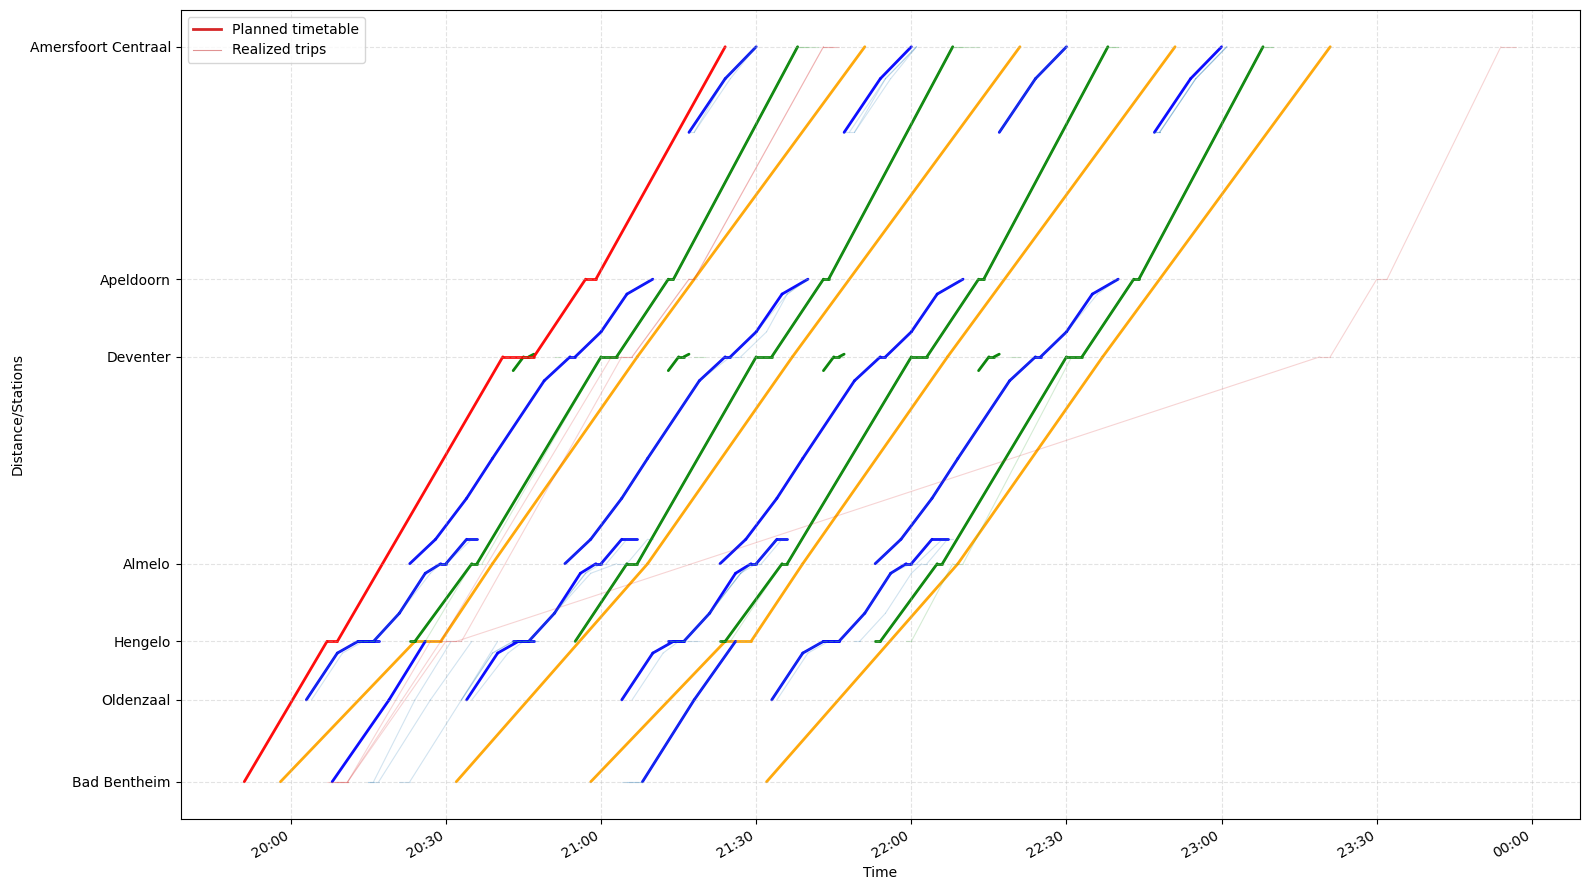

Het aantal dagen in deze dataset =  ['2025-05-05' '2025-06-19' '2025-10-25']


In [44]:
#ICE for which the time-distance diagram will be made. Make sure that you have the files mentioned below.
ICE_value = 140
df = pd.read_csv(f"Services/services_influenced_by_ICE_{ICE_value}.csv")
planned_timetable = pd.read_csv(f"Planned_timetables/planned_timetable_{ICE_value}.csv")

# Constructing a dictionary where the DataFrames will be stored
df_delay = {}

# Make a DataFrame for all trains at days where the ICE departs i minutes late from Bad Bentheim.
for i in range(60):
    late_rows = df[
        (df['Stop:Station name'] == 'Bad Bentheim') &
        (df['Stop:Departure delay'] == i) &
        (df['Service:Train number'] == ICE_value)
    ]

    dagen = late_rows['Service:Date'].unique()
    subset = df[df['Service:Date'].isin(dagen)]
    # Remove the trains from the dataset that are partially or completely cancelled
    subset_2 = subset[subset['Service:Partly cancelled'] != True]

    df_delay[i] = subset_2 

# Maak een dummy datum waar alle verschillende dagen op geprojecteerd worden
DUMMY_DATE = date(2024, 1, 1)

# Make a dictionary to couple the train type to the color
type_to_color = {
    "Intercity": "#2ca02c",  
    "Stoptrein": "#1f77b4", 
    "Sprinter": "#1f77b4",
    "ICE": "#d62728"         
}

def time_to_datetime(s):
    """ Convert all kinds of possible time string into the datetime format, if not present
    returns None
    
    Args: s (str): String containing the timestamp. Can be of every format ('07:41' or already in datetime format)

    Returns: Time in datetime format, date will be the dummy date selected
    """
    # If no time present, return none
    if pd.isna(s):
        return None
    
    # If the timestamp is already in datetime format, only keep the time and set date to dummy date
    if isinstance(s, datetime):
        dt = s.replace(tzinfo=None)
        return datetime.combine(DUMMY_DATE, time(dt.hour, dt.minute))
    
    # Otherwise, make it a string
    s = str(s).strip()

    # If this string contains a ':' and both sides of the ':' are at most 2 values
    # the string will look like "07:41" or "7:41". This means both sides can be used as hour and minute
    # which can be used in the datetime format
    if ":" in s and len(s.split(":")[0]) <= 2 and len(s.split(":")[1]) <= 2:
        parts = s.split(":")
        hh = int(parts[0]); mm = int(parts[1])
        return datetime.combine(DUMMY_DATE, time(hh, mm))
    
    # If this is not the case, a parser will be used to retrieve the hours and minutes
    try:
        dt = parser.parse(s)
        dt = dt.astimezone(tz=None).replace(tzinfo=None) if dt.tzinfo else dt
        return datetime.combine(DUMMY_DATE, time(dt.hour, dt.minute))
    except Exception:
        return None

def prepare_planned_segments(planned_df):
    """ Makes a list of all the data points of the planned timetable

    Args:
        planned_df (DataFrame): A DataFrame with the planned timetable, containing the rows
        'train_id', 'station', 'time' and 'color'
    
    Returns: 
        planned_segments (list): A list containing the segments of the planned timetable. Each entry of the list
        is a dictionary with the train_id, time stamp 1 (t1), time stamp 2 (t2), kilometer 1 (km1), kilometer 2 (km2) and the color
    """
    recs = []
    # For each row in the planned timetable DataFrame, collect the train_id, time, station (name & kilometer) and color
    for _, row in planned_df.iterrows():
        train = str(row["train_id"])
        st = row["station"]
        if st not in stations:
            continue
        dt = time_to_datetime(row["time"])
        if dt is None:
            continue
        color = row.get("color", None)
        recs.append({"train_id":train, "t":dt, "km":stations[st], "color":color, "station":st})
    if len(recs) == 0:
        return []
    dfp = pd.DataFrame(recs)


    planned_segments = []
    # Now for each group with the same train_id, sort them so they are in chronological order.
    # The next step is to make the points that need to be plotted (so a timestamp and a kilometer value)
    # Then, for each two neighbouring points a segment between them will be constructed containing both
    # time values and kilometer values. These will be all appended to the segments list.
    for train, g in dfp.groupby("train_id"):
        g = g.sort_values("t")
        color = g["color"].iloc[0]
        pts = list(zip(g["t"], g["km"]))
        for i in range(len(pts)-1):
            t1, km1 = pts[i]
            t2, km2 = pts[i+1]
            planned_segments.append({"train_id":train, "t1":t1, "km1":km1, "t2":t2, "km2":km2, "color":color})
    return planned_segments


def prepare_actual_segments(df_delay_i):
    """
    Build the actual (realised) time–distance segments for plotting.

    Args:
        df_delay_i (DataFrame): Contains all actual train data
                               (arrival/dep times + delays + station names)

    Returns:
        segments (list): List of dicts containing the line segments
    """

    segments = []  # Make a list where all the segments will be stored

    # Group by date + train number → each group is one realised train
    grouped = df_delay_i.groupby(["Service:Date", "Service:Train number"])

    for (svc_date, train), grp in grouped:

        station_pts = {}   # Make a dictionary where all the time-space-points will be saved

        # Process all stops of this group
        for _, row in grp.iterrows():
            st = row.get("Stop:Station name")

            # If the station is not in the stations dictionary, don't consider it
            if st not in stations:
                continue

            km = stations[st]

            # First, make all the points corresponding to arrivals
            # Retrieve the arrival time/delay from the DataFrame
            arr_raw = row.get("Stop:Arrival time")
            arr_delay_raw = row.get("Stop:Arrival delay")

            #Only use arrival data, when it is present. If it is present, transform the time into datetime format
            if pd.notna(arr_raw):
                try:
                    arr_plan = time_to_datetime(arr_raw)
                except:
                    arr_plan = None

                # If the planned time is found, make an integer out of the arrival delay. The actual arrival time
                # will be the planned arrival time plus the arrival delay. This will be saved in the datetime format
                # Lastly, this time stamp will be saved in the station_pts list.
                if arr_plan is not None:
                    arr_delay = int(arr_delay_raw)
                    arr_act = arr_plan + timedelta(minutes=arr_delay)
                    # Detect day rollover
                    day_offset = arr_act.date() - arr_plan.date()

                    # Create aligned datetime on dummy timeline
                    dt_arr = datetime.combine(DUMMY_DATE + day_offset, time(arr_act.hour, arr_act.minute))

                    station_pts.setdefault(st, [])
                    station_pts[st].append((dt_arr, km))

            # Now do the same thing for all the departure data of trains
            dep_raw = row.get("Stop:Departure time")
            dep_delay_raw = row.get("Stop:Departure delay")

            if pd.notna(dep_raw):
                try:
                    dep_plan = time_to_datetime(dep_raw)
                except:
                    dep_plan = None

                if dep_plan is not None:
                    dep_delay = int(dep_delay_raw)
                    dep_act = dep_plan + timedelta(minutes=dep_delay)
                    # Detect day rollover
                    day_offset = dep_act.date() - dep_plan.date()

                    # Create aligned datetime on dummy timeline
                    dt_dep = datetime.combine(DUMMY_DATE + day_offset, time(dep_act.hour, dep_act.minute))

                    station_pts.setdefault(st, [])
                    station_pts[st].append((dt_dep, km))

        # Now, make a list of all the points.
        all_pts = []
        for pts in station_pts.values():
            all_pts.extend(pts)

        # If there is only one point, don't plot this train 
        # This happens for train 1530, 1532 which only drove from Amersfoort in timetable 2024
        # and a few trains 36xx that only drove until Deventer because of works.
        if len(all_pts) < 2:
            continue

        # Sort the list in chronological order
        pts_list = sorted(all_pts, key=lambda x: x[0])

        # Now for the coloring of the trains, the train type will be retrieved.
        train_types = grp["Service:Type"].dropna().unique()
        train_type = train_types[0] if len(train_types) > 0 else None

        # Custom rule for ICE, because the ICE is called Intercity in most of the rows
        # As the influence of this train will be investigated, it is important that this train
        # gets a distinct color. All other trains will be colored based on their train type according
        # to the type_to_color dictionary
        if train == ICE_value:
            color = "#d62728"
        else:
            color = type_to_color.get(train_type, None)

        # The last step is to construct the segments of two neighbouring points and add them to the list
        for i in range(len(pts_list) - 1):
            t1, km1 = pts_list[i]
            t2, km2 = pts_list[i + 1]

            segments.append({
                "train_id": train,
                "t1": t1,
                "km1": km1,
                "t2": t2,
                "km2": km2,
                "color": color
            })

    return segments

def plot_segments(planned_segments, actual_segments, 
                  planned_alpha=0.95, actual_alpha=0.2,
                  planned_lw=2.0, actual_lw=0.8):
    """ Plot the planned segments and actual segments

    Args:
        planned_segments (list): The list made by the function prepare_planned_segments with the segments of the planned timetable
        actual_segments (list): The list made by the function prepare_actual_segments with the segments of the realized trips
        planned_alpha (float): The opacity of the segments of the planned timetable
        actual_alpha (float): The opacity of the segments of the realized trips
        planned_lw (float): Linewidth of segments of the planned timetable
        actual_lw (float): Linewidth of the segments of the realized trips
    
    Returns: None (Only output is a plot of the time-space diagram)
    """

    fig, ax = plt.subplots(figsize=(16, 9))

    # First, draw planned segments (zorder=1)
    for seg in planned_segments:
        ax.plot([seg["t1"], seg["t2"]], [seg["km1"], seg["km2"]],
                color=seg["color"], linewidth=planned_lw, alpha=planned_alpha, zorder=1, solid_capstyle='round')

    # Next, draw the actual realized trips on top (zorder=2)
    for seg in actual_segments:
        ax.plot([seg["t1"], seg["t2"]], [seg["km1"], seg["km2"]],
                color=seg["color"], linewidth=actual_lw, alpha=actual_alpha, zorder=2, solid_capstyle='round')

    # Set y-ticks only at the locations according to the stations_to_plot list
    station_names = [s for s in stations_to_plot]
    station_km = [stations[s] for s in stations_to_plot]
    ax.set_yticks(station_km)
    ax.set_yticklabels(station_names)

    # Formatting of the x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())

    # Construction of the legend
    legend_elems = [
        Line2D([0], [0], color="#d62728", lw=2, label="Planned timetable"),
        Line2D([0], [0], color="#cc4c4c", lw=0.8, alpha=0.6, label="Realized trips")
    ]
    ax.legend(handles=legend_elems, loc="upper left")

    ax.set_xlabel("Time")
    ax.set_ylabel("Distance/Stations")
    ax.grid(True, linestyle="--", alpha=0.35)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.savefig(f"Time-space diagram with realizations of ICE {ICE_value}.png", dpi=300)
    plt.show()

def plot_delay_over_planned(planned_df, df_delay_dict, i):
    """" Plot function when you only want to plot delays of trains at days when ICE depart i minutes late from Bad Bentheim

    Args:
        planned_df (DataFrame): DataFrame of the planned timetable (in long form)
        df_delay_dict (DataFrame): DataFrame of the actual realized trips on days where ICE departs i minutes late from Bad Bentheim
        i (int): Departure delay of ICE from Bad Bentheim

    Returns: None (Only output is a plot of the time-space diagram)
    """ 
    if i not in df_delay_dict:
        print(f"No df_delay for {i}")
        return
    df_delay_i = df_delay_dict[i]
    if df_delay_i is None or len(df_delay_i) == 0:
        print(f"No rows for a delay of {i} minutes")
        return

    planned_segments = prepare_planned_segments(planned_df)
    actual_segments = prepare_actual_segments(df_delay_i)
    plot_segments(planned_segments, actual_segments)


# Choose the delay value you want to plot here
delay_value = 20

# Plot the graph
plot_delay_over_planned(planned_timetable, df_delay, delay_value)
dagen_in_dataset = df_delay[delay_value]["Service:Date"].unique()
print("Het aantal dagen in deze dataset = ", dagen_in_dataset)

In [31]:
df_delay[9].to_csv("df_delay_9_minutes.csv", index=False)

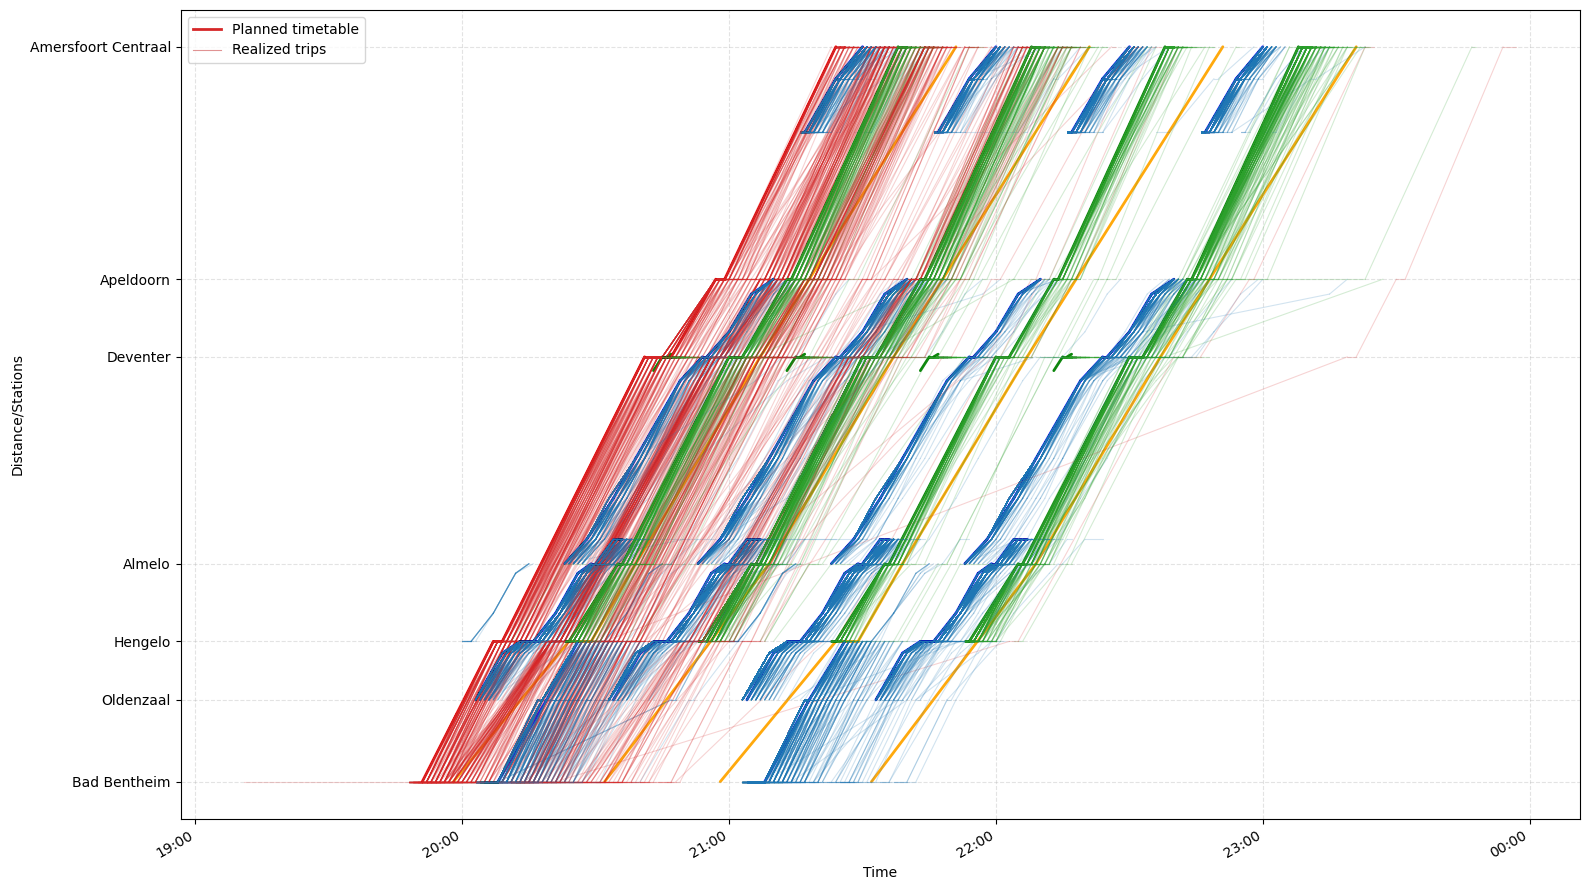

In [33]:
# Combine all delay values into one DataFrame
all_delays = pd.concat(df_delay.values(), ignore_index=True)

# Plot all the trains
plot_delay_over_planned(planned_timetable, {0: all_delays}, 0)